<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Newton-Fractal" data-toc-modified-id="Newton-Fractal-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Newton Fractal</a></span></li></ul></div>

In [1]:
from sympy.abc import x, y, a, b, c, d, e, f
from sympy.printing.aesaracode import aesara_function, aesara_code

import aesara
import aesara.tensor as at
from aesara.compile.builders import OpFromGraph
from aesara.scan.utils import until as scan_until

import numpy as np

cache_dict = {}

# Sympy equations
eq_1 = a * x ** 2 - b * y - c
eq_2 = d * x - e * y ** 2 + f
system = [eq_1, eq_2]

# Print sympy to aesara code
cache_dict = {}
params = [aesara_code(param, cache=cache_dict) for param in [a, b, c, d, e, f]]
variables = [aesara_code(var, cache=cache_dict) for var in [x, y]]

# Stack because we need vector outputs from F_x, J_x below
aesara_system = at.stack([aesara_code(eq, cache=cache_dict) for eq in system])
jacobian = at.stack([[at.grad(eq, x) for x in variables] for eq in aesara_system])

# Create callable functions on the graph from the sympy equations
F_x = OpFromGraph(params + variables, [aesara_system], name='F_x')
J_x = OpFromGraph(params + variables, [jacobian], name='J_x')

# Function parameters
step_size = at.dscalar('step_size')
max_iter = at.iscalar('max_iter')
tol  = at.dscalar('tol')


# Newton's Method
def newton_step(X, old_F, old_J, step_count, params, step_size, tol):
    
    new_X = X - step_size * at.linalg.solve(old_J, old_F)
    new_F = F_x(*params, *[new_X[i] for i in range(len(variables))])
    new_J = J_x(*params, *[new_X[i] for i in range(len(variables))])
    step_count += 1
    
    return (new_X, new_F, new_J, step_count), scan_until(at.linalg.norm(new_F, ord=1) < tol)

# Initial values
F0 = F_x(*params, *variables)
J0 = J_x(*params, *variables)

# Scan
result, updates = aesara.scan(newton_step,
                              outputs_info=[variables, F0, J0, at.zeros(1)],
                              non_sequences=[params, step_size, tol],
                              n_steps=max_iter)

roots, resids, jacobains, step_count = result
root = roots[-1]
resid = resids[-1]
jac = jacobian[-1]
steps = step_count[-1]

# Compile
f_newton = aesara.function(params + variables + [step_size, max_iter, tol], [root, resid, jac, steps], updates=updates)

Could not locate executable g77
Could not locate executable f77
Could not locate executable ifort
Could not locate executable ifl
Could not locate executable f90
Could not locate executable efl


# Newton Fractal

In [2]:
x0 = np.ones(2)
param_values = np.ones(6)

grid_size = 1000

x_range = np.linspace(-3.6, 3.6, grid_size)
y_range = np.linspace(-2.0, 2.0, grid_size)
heatmap = np.zeros((grid_size, grid_size))

for i, x in enumerate(x_range):
    for j, y in enumerate(y_range):        
        *_, n = f_newton(*param_values, x, y, step_size=1.0, max_iter=50, tol=1e-8)
        heatmap[j, i] = n

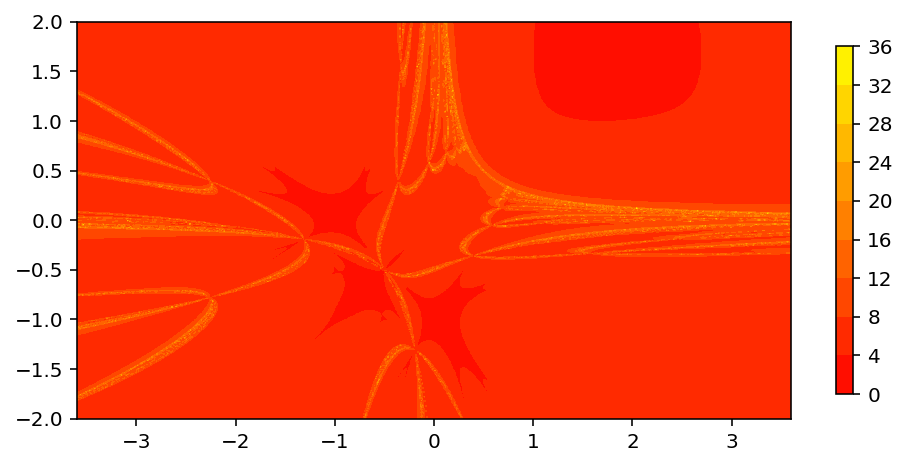

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,8), dpi=144)
xx, yy = np.meshgrid(x_range, y_range)
contours = ax.contourf(xx, yy, heatmap, cmap='autumn')
plt.colorbar(contours, shrink=0.4)
ax.set_aspect('equal')
fig.set_facecolor('white')
plt.show()